# Machine Learning Principles Final Assignment!


## data exploration

In [19]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_valid = pd.read_csv('valid.csv')

df_whole = pd.concat([df_train, df_valid, df_test], axis=0)

TRAINING INFORMATION


                                                text  label
0  states slow to shut down weak teacher educatio...      0
1    drone places fresh kill on steps of white house      1
2  report: majority of instances of people gettin...      1
3  sole remaining lung filled with rich, satisfyi...      1
4                       the gop's stockholm syndrome      0
distribution of labels
label
0    11248
1    10216
Name: count, dtype: int64


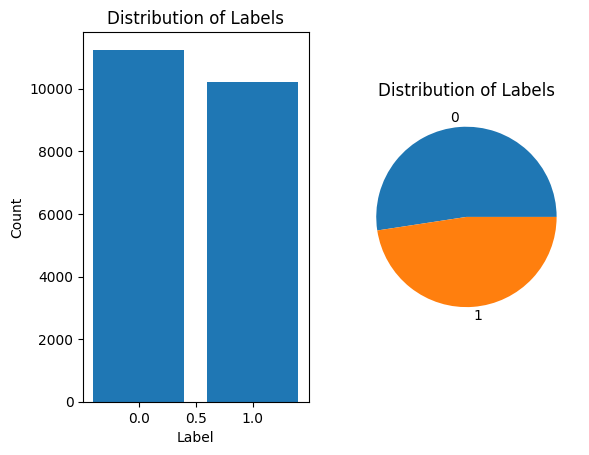

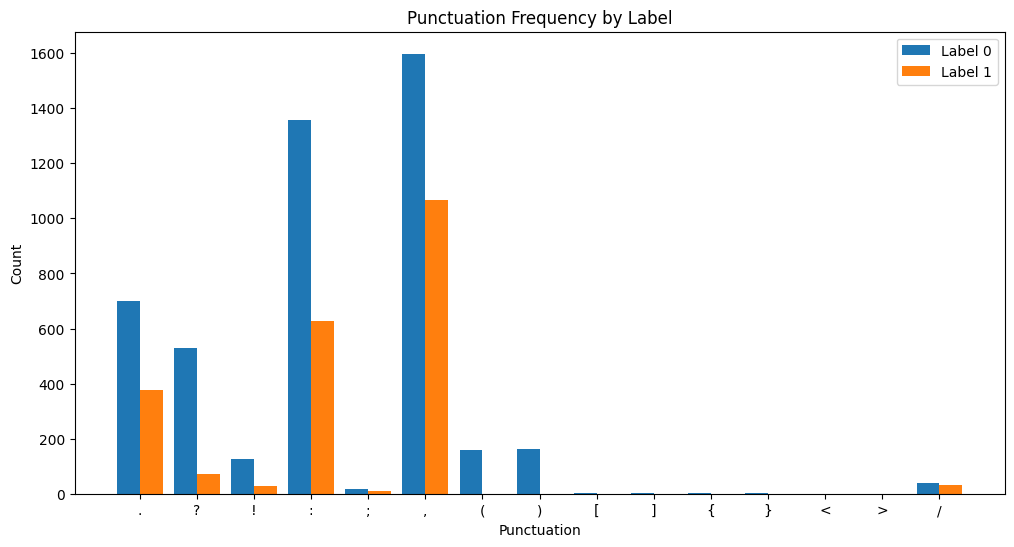

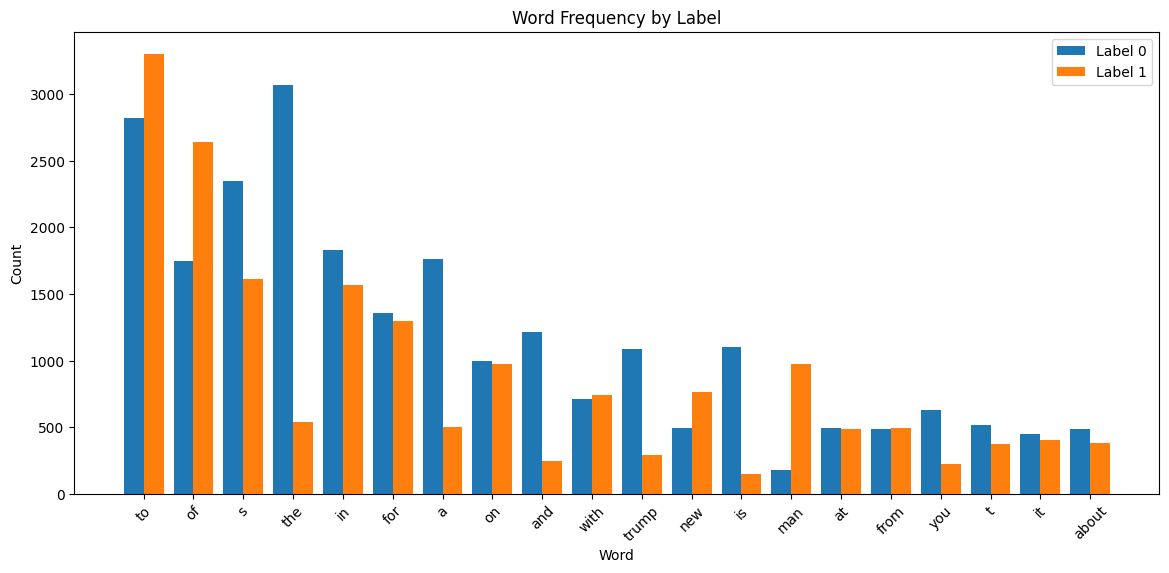

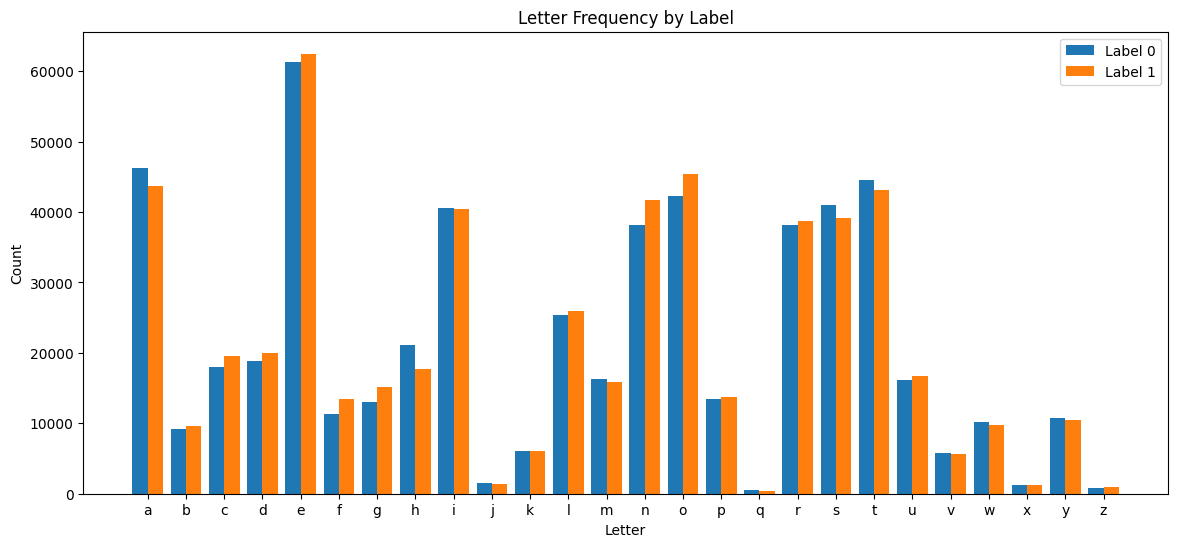

In [26]:
print("TRAINING INFORMATION")
print()
print()
print(df_train.head())
print("distribution of labels")

label_counts = df_train['label'].value_counts()
print(label_counts)
fig, ax = plt.subplots(1, 2)

ax[0].bar(label_counts.index, label_counts.values)
ax[0].set_title('Distribution of Labels')
ax[0].set_xlabel('Label')
ax[0].set_ylabel('Count')

ax[1].pie(label_counts.values, labels=label_counts.index)
ax[1].set_title('Distribution of Labels')

plt.show()


# for each label, show counts of punctuation
import re

punctuation = ['.', '?', '!', ':', ';', ',', '(', ')', '[', ']', '{', '}', '<', '>', '/']

rows = []

for label in df_train['label'].unique():
    texts = df_train[df_train['label'] == label]['text']
    for punct in punctuation:
        count = texts.str.contains(re.escape(punct)).sum()
        rows.append({
            'label': label,
            'punct': punct,
            'count': count
        })

punct_df = pd.DataFrame(rows)

labels = punct_df['label'].unique()
puncts = punctuation

x = np.arange(len(puncts))     
width = 0.8 / len(labels)      

fig, ax = plt.subplots(figsize=(12, 6))

for i, label in enumerate(labels):
    counts = punct_df[punct_df['label'] == label]['count']
    ax.bar(x + i*width, counts, width, label=f"Label {label}")

ax.set_xticks(x + width * (len(labels) - 1) / 2)
ax.set_xticklabels(puncts)
ax.set_xlabel("Punctuation")
ax.set_ylabel("Count")
ax.set_title("Punctuation Frequency by Label")
ax.legend()

plt.show()


from collections import Counter

# tokenize all text
all_words = []
for text in df_train['text']:
    all_words.extend(re.findall(r'\b\w+\b', text.lower()))

# pick top 20
most_common = [w for w, c in Counter(all_words).most_common(20)]
words = most_common

word_rows = []

for label in df_train['label'].unique():
    texts = df_train[df_train['label'] == label]['text']

    for w in words:
        # case-insensitive count of whole word
        count = texts.str.contains(rf'\b{re.escape(w)}\b', case=False).sum()
        
        word_rows.append({
            "label": label,
            "item": w,
            "count": count
        })

word_df = pd.DataFrame(word_rows)
import matplotlib.pyplot as plt
import numpy as np

labels = word_df['label'].unique()
items = words

x = np.arange(len(items))
width = 0.8 / len(labels)

fig, ax = plt.subplots(figsize=(14, 6))

for i, label in enumerate(labels):
    counts = word_df[word_df['label'] == label]['count']
    ax.bar(x + i*width, counts, width, label=f"Label {label}")

ax.set_xticks(x + width*(len(labels)-1)/2)
ax.set_xticklabels(items, rotation=45)
ax.set_xlabel("Word")
ax.set_ylabel("Count")
ax.set_title("Word Frequency by Label")
ax.legend()

plt.show()


import string
letters = list(string.ascii_lowercase)
import re

letter_rows = []

for label in df_train['label'].unique():
    texts = df_train[df_train['label'] == label]['text']

    for letter in letters:
        # count occurrences across all texts
        count = texts.str.count(letter).sum()
        
        letter_rows.append({
            "label": label,
            "item": letter,
            "count": count
        })

letter_df = pd.DataFrame(letter_rows)
labels = letter_df['label'].unique()
items = letters

x = np.arange(len(items))
width = 0.8 / len(labels)

fig, ax = plt.subplots(figsize=(14, 6))

for i, label in enumerate(labels):
    counts = letter_df[letter_df['label'] == label]['count']
    ax.bar(x + i*width, counts, width, label=f"Label {label}")

ax.set_xticks(x + width*(len(labels)-1)/2)
ax.set_xticklabels(items)
ax.set_xlabel("Letter")
ax.set_ylabel("Count")
ax.set_title("Letter Frequency by Label")
ax.legend()

plt.show()



In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

# TF-IDF
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1,2),   # unigrams + bigrams work best
    max_features=10000
)

X = tfidf.fit_transform(df_train['text'])
y = df_train['label']
clf = LogisticRegression(max_iter=2000)
clf.fit(X, y)
feature_names = np.array(tfidf.get_feature_names_out())
coeffs = clf.coef_[0]

# Top positive features (predict label=1)
top_pos = feature_names[np.argsort(coeffs)[-20:]]

# Top negative features (predict label=0)
top_neg = feature_names[np.argsort(coeffs)[:20]]

print("Top features for LABEL=1:")
print(top_pos)

print("\nTop features for LABEL=0:")
print(top_neg)


Top features for LABEL=1:
['hours' 'bush' 'forced' 'unveils' 'romney' 'entire' 'kavanaugh' 'onion'
 'clearly' 'fuck' 'shit' 'study' 'introduces' 'announces' 'local'
 'fucking' 'area' 'report' 'man' 'nation']

Top features for LABEL=0:
['trump' 'donald' 'cops' 'donald trump' 'watch' 'need' 'reasons' 'muslim'
 '2015' 'trans' 'transgender' 'women' 'allegedly' 'want' 'ways' 'photos'
 '2014' 'queer' 'twitter' 'lessons']


In [28]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y)
mi_scores = pd.Series(mi, index=tfidf.get_feature_names_out())
mi_scores = mi_scores.sort_values(ascending=False)

print(mi_scores.head(20))


/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/opt

trump           0.043405
new             0.041348
man             0.040030
just            0.016194
report          0.015551
woman           0.013860
year            0.013817
area            0.013116
day             0.012594
time            0.012269
like            0.011153
donald          0.011044
says            0.010918
donald trump    0.010761
nation          0.010734
old             0.010477
obama           0.010010
people          0.009792
house           0.009790
life            0.009682
dtype: float64


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1,2),
    max_features=15000
)

X = vectorizer.fit_transform(df_train["text"])
y = df_train["label"]

models = [
    ("lr", LogisticRegression(max_iter=1500)),
    ("svm", LinearSVC()),
    ("nb", ComplementNB()),
    ("ridge", RidgeClassifier())
]

ensemble = VotingClassifier(
    estimators=models,
    voting='soft'  # use averaged probabilities
)

ensemble.fit(X, y)


,estimators,"[('lr', ...), ('svm', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
